# Overview of the Nikkei225 and their option

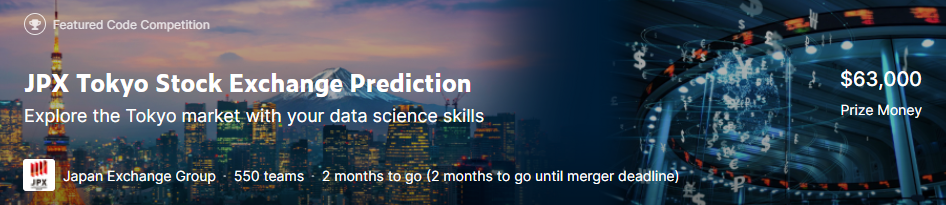


In [ ]:
!pip install yfinance
import os
import datetime
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from mpl_toolkits.mplot3d import Axes3D

In [ ]:
# import options.csv
# dataset_dir = '../data/input/'
dataset_dir='../input/jpx-tokyo-stock-exchange-prediction/'

options = pd.read_csv(os.path.join(dataset_dir, 'train_files', 'options.csv'), parse_dates=['Date'])
options

In [ ]:
# get nikkei225 as underlying asset of an option
nikkei225 = yf.download('^N225', preriod='max', interval='1d')
# add the strike price for an option
nikkei225['StrikePrice'] = (round(nikkei225['Close']/250., 0) * 250).astype(int)
nikkei225

### Nikkei225 chart as the underlying asset of an option

In [ ]:
plt.figure(figsize = (20,4))
plt.title('Nikkei225')
plt.plot(nikkei225.loc[min(options['Date']):max(options['Date']),'Close'])
plt.show()

## Overview of implied volatility

In [ ]:
extracted = options[(options['TradingVolume']>0)][['Date', 'TradingVolume', 'OpenInterest', 'Putcall', 'ContractMonth', 'StrikePrice', 'SettlementPrice', 'BaseVolatility', 'ImpliedVolatility']]
extracted = extracted.groupby(['Putcall', 'Date', 'StrikePrice'], as_index=False).apply(lambda x: x.sort_values(['TradingVolume','ContractMonth'], ascending=[False,True]).iloc[0])
put = extracted[extracted['Putcall']==1].reset_index(drop=True)
call = extracted[extracted['Putcall']==2].reset_index(drop=True)

### Implied volatility scatter

In [ ]:
fig = plt.figure(figsize = (20, 10))
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')

### put option
min_date = min(put['Date'])
x = pd.to_numeric((put['Date'] - min_date).dt.days, downcast='integer')
y = put['StrikePrice']
z = put['ImpliedVolatility']

sc = ax1.scatter3D(x, y, z, c=z, cmap=mpl.cm.jet)
fig.colorbar(sc, shrink=0.5, aspect=20, ax=ax1)
ax1.set_title('Implied volatility transition of put option, per strike price')
ax1.set_xlabel('Date')
ax1.set_ylabel('Strike price')
ax1.set_zlabel('Implied volatility')

# fixing xticks with matplotlib.ticker 'FixedLocator'
xticks = ax1.get_xticks().tolist()
ax1.xaxis.set_major_locator(mticker.FixedLocator(xticks))
ax1.set_xticklabels([f'{(min_date + datetime.timedelta(days=x)).strftime("%y/%m/%d")}' for x in xticks])

### call option
min_date = min(call['Date'])
x = pd.to_numeric((call['Date'] - min_date).dt.days, downcast='integer')
y = call['StrikePrice']
z = call['ImpliedVolatility']

sc = ax2.scatter3D(x, y, z, c=z, cmap=mpl.cm.jet)
fig.colorbar(sc, shrink=0.5, aspect=20, ax=ax2)
ax2.set_title('Implied volatility transition of call option, per strike price')
ax2.set_xlabel('Date')
ax2.set_ylabel('Strike price')
ax2.set_zlabel('Implied volatility')

# fixing xticks with matplotlib.ticker 'FixedLocator'
xticks = ax2.get_xticks().tolist()
ax2.xaxis.set_major_locator(mticker.FixedLocator(xticks))
ax2.set_xticklabels([f'{(min_date + datetime.timedelta(days=x)).strftime("%y/%m/%d")}' for x in xticks])

plt.show()

### Implied volatility at ATM

In [ ]:
merged = nikkei225[min(options['Date']):max(options['Date'])]
merged = pd.merge(merged, put[['Date', 'StrikePrice', 'ImpliedVolatility']], on=['Date', 'StrikePrice'], how='left', indicator=False)
merged = pd.merge(merged, call[['Date', 'StrikePrice', 'ImpliedVolatility']], on=['Date', 'StrikePrice'], how='left', indicator=False)
merged

In [ ]:
merged.columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'StrikePrice', 'ImpliedVolatility_put', 'ImpliedVolatility_call']
merged[(merged['ImpliedVolatility_put'].isna()) | (merged['ImpliedVolatility_call'].isna())]

In [ ]:
merged['ImpliedVolatility_put'].ffill(inplace=True)
merged['ImpliedVolatility_call'].ffill(inplace=True)

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(20,10), sharex=True, tight_layout=True)
ax[0].plot(merged['Date'], merged['Close'])
ax[1].plot(merged['Date'], merged['ImpliedVolatility_put'])
ax[2].plot(merged['Date'], merged['ImpliedVolatility_call'])
ax[0].set_title('Nikkei225')
ax[1].set_title('Implied volatility at ATM of put option')
ax[2].set_title('Implied volatility at ATM of call option')
plt.show()